# Multi-class classification of Brain tumour types using MR Images

**Artificial Intelligence and Machine Learning Framework Through Waterfall project management methodology 
**
*    Explortoy Data Analysis
*    Data Preprocessing
*    Model Development
*    Model Training
    *    Hyperparameter tuning
    *    Repeat until satisfied
*    Model Evaluation
*    Save Model



# Importing the nesscessary libraries:

In [1]:
from PIL import Image
import numpy as np
import os
import pandas as pd
from scipy import ndimage 
from pathlib import Path
import matplotlib.pyplot as plt 
import pathlib
import random
from sklearn.utils import shuffle
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import EfficientNetB0
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

2024-05-14 16:02:36.892613: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 16:02:36.892817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 16:02:37.080172: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Exploratory Data analysis

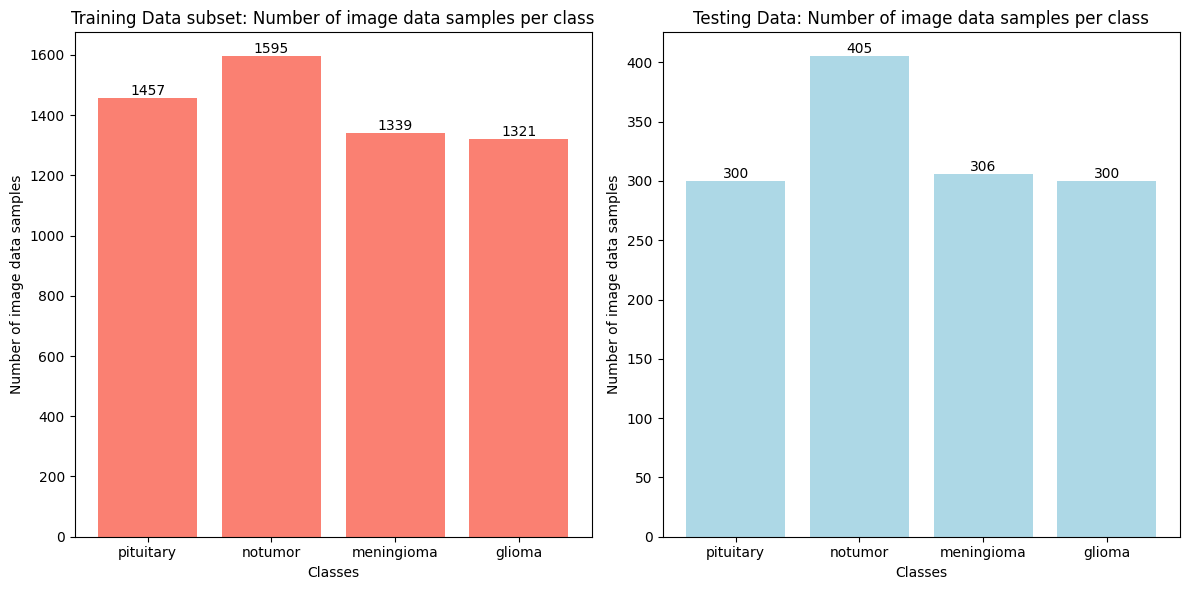

In [2]:
training_counts, testing_counts = {}, {}
for dirpath, _, filenames in os.walk("/kaggle/input/brain-tumor-mri-dataset/"):
    if filenames:
        class_name = dirpath.split("/")[-1]
        num_images = len(filenames)
        if "Testing" in dirpath:
            testing_counts[class_name] = num_images
        elif "Training" in dirpath:
            training_counts[class_name] = num_images
training_df = pd.DataFrame(training_counts.items(), columns=['Class', 'Number of Images'])
testing_df = pd.DataFrame(testing_counts.items(), columns=['Class', 'Number of Images'])
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
bars = plt.bar(training_df['Class'], training_df['Number of Images'], color='salmon')
plt.xlabel('Classes')
plt.ylabel('Number of image data samples')
plt.title('Training Data subset: Number of image data samples per class')
for bar, count in zip(bars, training_df['Number of Images']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count, ha='center', va='bottom')
plt.subplot(1, 2, 2)
bars = plt.bar(testing_df['Class'], testing_df['Number of Images'], color='lightblue')
plt.xlabel('Classes')
plt.ylabel('Number of image data samples')
plt.title('Testing Data: Number of image data samples per class')
for bar, count in zip(bars, testing_df['Number of Images']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count, ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [3]:
# setup train and test directories paths
training_data_directory = "/kaggle/input/brain-tumor-mri-dataset/Training"
testing_data_directory = "/kaggle/input/brain-tumor-mri-dataset/Testing"

In [4]:
# let's get the subdirectories in these main training and testing directories
#  which are the target class names
data_directory = pathlib.Path(training_data_directory)
class_names = np.array(sorted([item.name for item in data_directory.glob('*')]))
print(class_names)

['glioma' 'meningioma' 'notumor' 'pituitary']


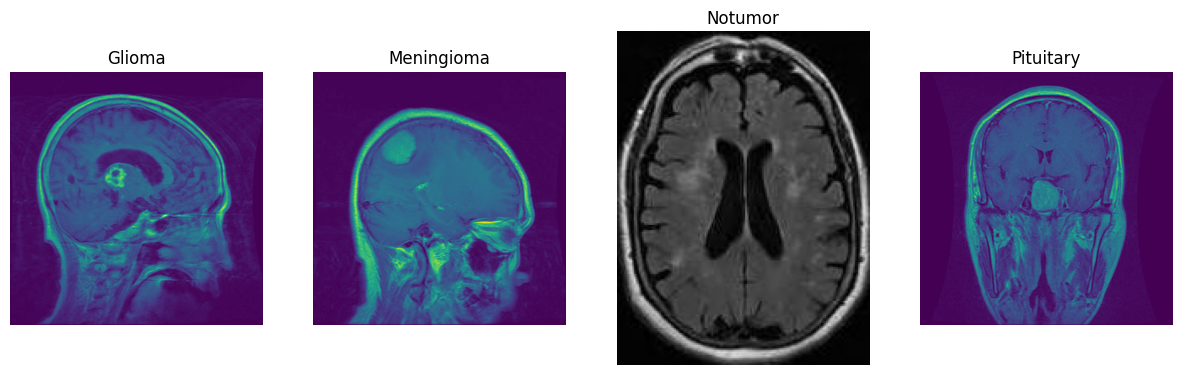

In [5]:
def view_random_image(target_directory, target_classes, num_images):
    # Setup the target directory (to view images from here)
    num_classes = len(target_classes)
    fig, axs = plt.subplots(1, min(num_images, num_classes), figsize=(15, 5))  
    for i, target_class in enumerate(target_classes):
        if i >= num_images:
            break  # Exit loop if we have displayed the desired number of images
            
        target_folder = os.path.join(target_directory, target_class)
        
        # Get a random image path
        random_image = random.sample(os.listdir(target_folder), 1)[0]
        
        # Read in the image
        image = plt.imread(os.path.join(target_folder, random_image))
        
        # Plot the image in the corresponding subplot
        axs[i].imshow(image)
        axs[i].set_title(str(target_class).replace("_", " ").title())
        axs[i].axis("off")
    plt.show()  # Show the plot

view_random_image(target_directory=training_data_directory,
                  target_classes=class_names,
                  num_images=4) 


# Preprocessing


### Converting all image data to RGB scale, standardising all image data sizes to 224 x 224, scaling all image data through normalisation, and reducing noise by applying Gaussian blur to all image data.




In [6]:
def load_and_preprocess_images(directory_path, dict_mapping, target_size=(224, 224), sigma=0.5):
    image_data = []
    labels = []
    for label in dict_mapping:
        directory = os.path.join(directory_path, label) # Joining of directory path and class name
        for filename in os.listdir(directory):
            img = Image.open(os.path.join(directory, filename))  # Open the file
            # Convert image to RGB
            if img.mode != 'RGB':
                img = img.convert('RGB')
            # Resize image
            img = img.resize(target_size)  
            # Convert to NumPy array for normalisation
            img = np.array(img)
            # Normalisation
            img = img / 255.0  # Divide each pixel value by 255.0
            # Gaussian blur for noise reduction 
            if sigma > 0:
                img = ndimage.gaussian_filter(img, sigma=sigma)
            # Append the images and labels to the lists
            image_data.append(img)
            labels.append(dict_mapping[label])

    return np.array(image_data), np.array(labels)


## Initalising and preprocessing Training and Testing data subsets of the orignal dataset

In [7]:
dict_mapping = {'glioma': 0, 'meningioma':1, 'notumor': 2, 'pituitary': 3}

x_train, y_train = load_and_preprocess_images(training_data_directory, dict_mapping, (224, 224))
x_train, y_train = shuffle(x_train,y_train, random_state=42)

x_test, y_test = load_and_preprocess_images(testing_data_directory, dict_mapping, (224, 224))
x_test, y_test = shuffle(x_test,y_test, random_state=42)

##  Data Balancing through oversampling the minority classes using SMOTE

In [8]:
smote = SMOTE(k_neighbors=5, random_state=42)
x_train_reshaped = x_train.reshape(-1, 224*224*3) 
x_train, y_train = smote.fit_resample(x_train_reshaped, y_train)
x_train = x_train.reshape(-1, 224, 224, 3)  # Reshape after oversampling

oversampled_class_counts = Counter(y_train)
print("SMOTE-Oversampled Training Data Class Distribution: \n")
for class_label, count in oversampled_class_counts.items():
  print(f"{class_names[class_label].title()}: {count} samples")

SMOTE-Oversampled Training Data Class Distribution: 

Meningioma: 1595 samples
Notumor: 1595 samples
Glioma: 1595 samples
Pituitary: 1595 samples


# Visualisation of the balanced preprocessed MRI data

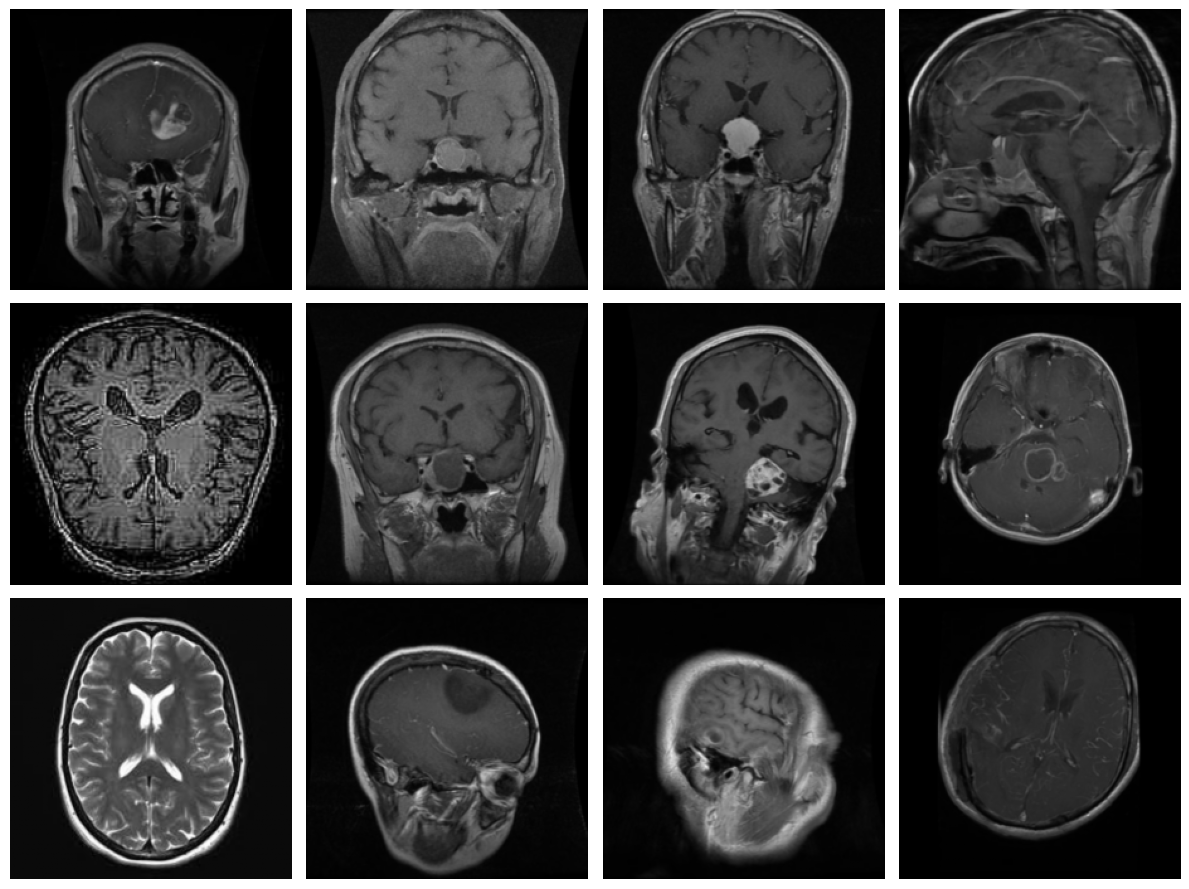

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))
axes = axes.flatten()

for i in range(12):
    random_image = random.choice(x_train)
    axes[i].imshow(random_image)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Data Splitting (Training set = 60%, Validation = 20%, Testing = 20%)

In [9]:
# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

## Data Augmentation

In [10]:
# Create new training data generators
training_data_generator = ImageDataGenerator(rotation_range= 0.2,
                                             zoom_range= 0.2,
                                             width_shift_range= 0.2,
                                             horizontal_flip = True)

> N.B. The warning prompt will apear but it's fine. 

## Model Development

In [11]:
# Create a CNN model
cnn_model1 = Sequential([
    Conv2D(10, 3, activation= "relu", input_shape= (224, 224, 3)),
    Dropout(rate= 0.2),
    MaxPool2D(),

    Conv2D(filters= 10, kernel_size=(3, 3), activation= "relu"),
    MaxPool2D(),

    Conv2D(filters= 10, kernel_size=(3, 3), activation= "relu"),
    Dropout(rate= 0.2),
    MaxPool2D(),

    Conv2D(filters= 10, kernel_size=(3, 3), activation= "relu"),
    MaxPool2D(),

    Conv2D(filters= 10, kernel_size=(3, 3), activation= "relu"),
    MaxPool2D(),
    Flatten(),

    Dense(4, activation= "softmax"),
])

# Compile the model
cnn_model1.compile(
    loss= "sparse_categorical_crossentropy",
    optimizer= tf.keras.optimizers.Adam(),
    metrics= ['accuracy']
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [14]:
# Create a model
cnn_model2 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    BatchNormalization(),
    Conv2D(filters=10, kernel_size=3, activation="relu"),
    BatchNormalization(),
    MaxPool2D(),
    Dense(128, activation="relu"),
    Conv2D(filters=10, kernel_size=3, activation="relu"),
    BatchNormalization(),
    Conv2D(filters=10, kernel_size=3, activation="relu"),
    BatchNormalization(),
    MaxPool2D(),
    Dense(128, activation="relu"),
    Conv2D(filters=10, kernel_size=3, activation="relu"),
    BatchNormalization(), 
    Conv2D(filters=10, kernel_size=3, activation="relu"),
    BatchNormalization(),
    MaxPool2D(),
    Dense(128, activation="relu"),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(4, activation="softmax")
])

# Compile the model
cnn_model2.compile(
    loss= "sparse_categorical_crossentropy",
    optimizer= tf.keras.optimizers.Adam(),
    metrics= ['accuracy']
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [11]:
# Create a model
cnn_model3 = Sequential([
    Conv2D(16, 3, activation="relu", input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(filters=32, kernel_size=3, activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(filters=64, kernel_size=3, activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(512, activation="relu"),
    Dense(4, activation="softmax")
])

# Compile the model
cnn_model3.compile(
    loss= "sparse_categorical_crossentropy",
    optimizer= tf.keras.optimizers.Adam(),
    metrics= ['accuracy']
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [12]:
# Create a model
cnn_model4 = Sequential([
    Conv2D(32, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(filters=64, kernel_size=3, activation="relu"),
    MaxPooling2D(2, 2),

    Conv2D(filters=128, kernel_size=3, activation="relu"),
    MaxPooling2D(2, 2),

    Conv2D(filters=256, kernel_size=3, activation="relu"),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(512, activation="relu"),
    Dense(4, activation="softmax")
])

# Compile the model
cnn_model4.compile(
    loss= "sparse_categorical_crossentropy",
    optimizer= tf.keras.optimizers.Adam(),
    metrics= ['accuracy']
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [13]:
# Create a model
cnn_model5 = Sequential([
    Conv2D(32, 3, activation=LeakyReLU(), padding="same", input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(filters=64, kernel_size=3, activation=LeakyReLU(), padding="same"),# LeakyRelu activation used here
    MaxPooling2D(2, 2),

    Conv2D(filters=128, kernel_size=3, activation=LeakyReLU(), padding="same"),
    MaxPooling2D(2, 2),

    Conv2D(filters=256, kernel_size=3, activation=LeakyReLU(), padding="same"),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(512, activation=LeakyReLU()),
    Dense(4, activation="softmax")
])

# Compile the model with Nesterov mementum = 0.99 SGD
cnn_model5.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.99, nesterov=True),
    metrics=['accuracy']
)


In [10]:
# Create a model
cnn_model6 = Sequential([
    Conv2D(32, 3, activation="relu", padding="same", input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(filters=64, kernel_size=3, activation="relu", padding="same"),
    MaxPooling2D(2, 2),

    Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),
    MaxPooling2D(2, 2),

    Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(512, activation="relu"),
    Dense(4, activation="softmax") 
])

# Compile the model with sparse categorical crossentropy loss
cnn_model6.compile(
    loss="sparse_categorical_crossentropy",  
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.99, nesterov=True),
    metrics=['accuracy']
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [15]:
# Define the input image size 
image_size = 224  

# Specify the path to pre-trained weights
weights_path = '/kaggle/input/inception-v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Create the InceptionV3 model with pre-trained weights
inception_base = InceptionV3(weights=weights_path, include_top=False, input_shape=(image_size, image_size, 3))

inception_base.trainable = False

# Create the final classifier model
model_inception_v3 = Sequential([
    inception_base,
    Flatten(),
    Dense(units=512, activation='relu'),  
    Dense(4, activation='softmax')  
])

# Compile the model
model_inception_v3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Define the input image size 
image_size = 224  

# Specify the path to pre-trained weights
weights_path = '/kaggle/input/densenet/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Create the DenseNet121 model with pre-trained weights
densenet_base = DenseNet121(weights=weights_path, include_top=False, input_shape=(image_size, image_size, 3))

densenet_base.trainable = False

# Create the final classifier model
model_densenet121 = Sequential([
    densenet_base,
    Flatten(),
    Dense(units=512, activation='relu'),  
    Dense(4, activation='softmax')  
])

# Compile the model
model_densenet121.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Define the input image size
image_size = 224

# Specify the path to pre-trained weights
weights_path = '/kaggle/input/efficientnet/efficientnetb0_notop.h5'

# Create the EfficientNetB0 model with pre-trained weights
efficientnet_base = EfficientNetB0(weights=weights_path, include_top=False, input_shape=(image_size, image_size, 3))

efficientnet_base.trainable = False

# Create the final classifier model
model_efficientnet_b0 = Sequential([
    efficientnet_base,
    Flatten(),
    Dense(units=512, activation='relu'),  
    Dense(4, activation='softmax')  
])

# Compile the model
model_efficientnet_b0.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


## Model Training

In [12]:
# Fit the cnn_model with training data
cnn_history1 = cnn_model1.fit(training_data_generator.flow(x_train, y_train, batch_size=32),
                        epochs= 70,
                        validation_data=(x_val,y_val))

Epoch 1/70


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 141s 839ms/step - accuracy: 0.3047 - loss: 1.3467 - val_accuracy: 0.6089 - val_loss: 1.0038
Epoch 2/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 135s 806ms/step - accuracy: 0.6331 - loss: 0.9553 - val_accuracy: 0.6513 - val_loss: 0.9151
Epoch 3/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 142s 806ms/step - accuracy: 0.6551 - loss: 0.8765 - val_accuracy: 0.6223 - val_loss: 0.8909
Epoch 4/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 141s 798ms/step - accuracy: 0.6848 - loss: 0.8015 - val_accuracy: 0.6693 - val_loss: 0.8048
Epoch 5/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 143s 803ms/step - accuracy: 0.7164 - loss: 0.7135 - val_accuracy: 0.5799 - val_loss: 0.8747
Epoch 6/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 141s 796ms/step - accuracy: 0.7253 - loss: 0.6841 - val_accuracy: 0.6889 - val_loss: 0.7275
Epoch 7/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 142s 797ms/step - accuracy: 0.7451 - loss: 0.6462 - val_accuracy: 0.6097 - val_loss: 0.8429
Epoch 8/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 144s 812ms/step - accuracy: 0.7357 - loss: 0.64

In [15]:
# Fit the cnn_model with training data
cnn_history2 = cnn_model2.fit(training_data_generator.flow(x_train, y_train, batch_size=32),
                        epochs= 70,
                        validation_data=(x_val,y_val))

Epoch 1/70


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 605s 4s/step - accuracy: 0.5416 - loss: 2.7983 - val_accuracy: 0.2249 - val_loss: 1.6488
Epoch 2/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 588s 4s/step - accuracy: 0.7297 - loss: 0.6905 - val_accuracy: 0.4514 - val_loss: 1.1430
Epoch 3/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 538s 3s/step - accuracy: 0.7801 - loss: 0.5699 - val_accuracy: 0.6371 - val_loss: 0.8783
Epoch 4/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 547s 3s/step - accuracy: 0.7746 - loss: 0.5702 - val_accuracy: 0.7759 - val_loss: 0.5018
Epoch 5/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 543s 3s/step - accuracy: 0.7838 - loss: 0.5240 - val_accuracy: 0.6591 - val_loss: 0.8738
Epoch 6/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 533s 3s/step - accuracy: 0.8162 - loss: 0.4671 - val_accuracy: 0.6536 - val_loss: 0.9018
Epoch 7/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 513s 3s/step - accuracy: 0.8120 - loss: 0.4678 - val_accuracy: 0.6630 - val_loss: 1.0507
Epoch 8/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 481s 3s/step - accuracy: 0.8182 - loss: 0.4672 - val_accuracy: 0.732

In [12]:
#[# Fit the cnn_model with training data
cnn_history3 = cnn_model3.fit(training_data_generator.flow(x_train, y_train, batch_size=32),
                        epochs= 70,
                        validation_data=(x_val,y_val))

Epoch 1/70


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.5397 - loss: 4.8047 - val_accuracy: 0.2524 - val_loss: 34.5719
Epoch 2/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.7036 - loss: 0.7489 - val_accuracy: 0.3542 - val_loss: 2.1233
Epoch 3/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.7564 - loss: 0.6388 - val_accuracy: 0.7147 - val_loss: 0.6990
Epoch 4/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.7776 - loss: 0.5692 - val_accuracy: 0.5752 - val_loss: 1.4416
Epoch 5/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.7764 - loss: 0.5783 - val_accuracy: 0.5055 - val_loss: 1.8284
Epoch 6/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.8071 - loss: 0.5079 - val_accuracy: 0.6599 - val_loss: 0.9586
Epoch 7/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.8135 - loss: 0.4823 - val_accuracy: 0.5462 - val_loss: 1.6235
Epoch 8/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.8332 - loss: 0.4465 - val_accuracy: 0.65

In [13]:
# Fit the cnn_model with training data
cnn_history4 = cnn_model4.fit(training_data_generator.flow(x_train, y_train, batch_size=32),
                        epochs= 70,
                        validation_data=(x_val,y_val))

Epoch 1/70


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 435s 3s/step - accuracy: 0.4742 - loss: 1.1559 - val_accuracy: 0.6834 - val_loss: 0.7663
Epoch 2/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 425s 3s/step - accuracy: 0.6898 - loss: 0.7752 - val_accuracy: 0.7868 - val_loss: 0.5289
Epoch 3/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 450s 3s/step - accuracy: 0.7478 - loss: 0.6011 - val_accuracy: 0.7171 - val_loss: 0.7003
Epoch 4/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 414s 3s/step - accuracy: 0.7708 - loss: 0.5730 - val_accuracy: 0.7766 - val_loss: 0.5428
Epoch 5/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 440s 3s/step - accuracy: 0.7882 - loss: 0.5282 - val_accuracy: 0.8260 - val_loss: 0.4054
Epoch 6/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 406s 3s/step - accuracy: 0.8089 - loss: 0.4695 - val_accuracy: 0.8417 - val_loss: 0.3740
Epoch 7/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 444s 3s/step - accuracy: 0.8459 - loss: 0.4034 - val_accuracy: 0.8754 - val_loss: 0.3184
Epoch 8/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 415s 3s/step - accuracy: 0.8571 - loss: 0.3760 - val_accuracy: 0.862

In [14]:
# Fit the cnn_model with training data
cnn_history5 = cnn_model5.fit(training_data_generator.flow(x_train, y_train, batch_size=32),
                        epochs= 70,
                        validation_data=(x_val,y_val))

Epoch 1/70


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 455s 3s/step - accuracy: 0.3822 - loss: 1.2563 - val_accuracy: 0.6575 - val_loss: 0.8862
Epoch 2/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 500s 3s/step - accuracy: 0.6523 - loss: 0.8901 - val_accuracy: 0.7367 - val_loss: 0.7046
Epoch 3/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 450s 3s/step - accuracy: 0.7050 - loss: 0.7177 - val_accuracy: 0.7696 - val_loss: 0.6152
Epoch 4/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 448s 3s/step - accuracy: 0.7418 - loss: 0.6312 - val_accuracy: 0.7743 - val_loss: 0.5954
Epoch 5/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 502s 3s/step - accuracy: 0.7708 - loss: 0.5676 - val_accuracy: 0.7868 - val_loss: 0.5539
Epoch 6/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 452s 3s/step - accuracy: 0.8002 - loss: 0.5056 - val_accuracy: 0.7978 - val_loss: 0.5171
Epoch 7/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 450s 3s/step - accuracy: 0.8141 - loss: 0.4783 - val_accuracy: 0.8111 - val_loss: 0.4783
Epoch 8/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 449s 3s/step - accuracy: 0.8212 - loss: 0.4740 - val_accuracy: 0.815

In [11]:
# Fit the cnn_model with training data
cnn_history6 = cnn_model6.fit(training_data_generator.flow(x_train, y_train, batch_size=32),
                        epochs= 70,
                        validation_data=(x_val,y_val))

Epoch 1/70


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 445s 3s/step - accuracy: 0.3186 - loss: 1.3047 - val_accuracy: 0.6183 - val_loss: 0.9651
Epoch 2/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 489s 3s/step - accuracy: 0.6175 - loss: 0.9342 - val_accuracy: 0.6936 - val_loss: 0.7825
Epoch 3/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 441s 3s/step - accuracy: 0.6800 - loss: 0.8242 - val_accuracy: 0.7257 - val_loss: 0.6639
Epoch 4/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 442s 3s/step - accuracy: 0.7252 - loss: 0.6950 - val_accuracy: 0.7955 - val_loss: 0.5111
Epoch 5/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 441s 3s/step - accuracy: 0.7741 - loss: 0.5882 - val_accuracy: 0.8041 - val_loss: 0.4808
Epoch 6/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 441s 3s/step - accuracy: 0.7871 - loss: 0.5335 - val_accuracy: 0.8284 - val_loss: 0.4186
Epoch 7/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 441s 3s/step - accuracy: 0.8061 - loss: 0.4912 - val_accuracy: 0.8519 - val_loss: 0.3723
Epoch 8/70
160/160 ━━━━━━━━━━━━━━━━━━━━ 426s 3s/step - accuracy: 0.8315 - loss: 0.4320 - val_accuracy: 0.861

In [16]:
# Fit the cnn_model with training data
cnn_history7 = model_inception_v3.fit(training_data_generator.flow(x_train, y_train, batch_size=32),
                        epochs= 50,
                        validation_data=(x_val,y_val))

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 469s 3s/step - accuracy: 0.6269 - loss: 12.1041 - val_accuracy: 0.8103 - val_loss: 0.9556
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 443s 3s/step - accuracy: 0.8340 - loss: 0.6589 - val_accuracy: 0.8840 - val_loss: 0.3042
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 450s 3s/step - accuracy: 0.8884 - loss: 0.3098 - val_accuracy: 0.8903 - val_loss: 0.3063
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 497s 3s/step - accuracy: 0.8905 - loss: 0.2942 - val_accuracy: 0.8997 - val_loss: 0.2528
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 519s 3s/step - accuracy: 0.9134 - loss: 0.2384 - val_accuracy: 0.9067 - val_loss: 0.2560
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 449s 3s/step - accuracy: 0.9258 - loss: 0.2053 - val_accuracy: 0.9216 - val_loss: 0.2241
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 449s 3s/step - accuracy: 0.9259 - loss: 0.1992 - val_accuracy: 0.9303 - val_loss: 0.1967
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 448s 3s/step - accuracy: 0.9227 - loss: 0.1981 - val_accuracy: 0.92

In [20]:
# Fit the cnn_model with training data
cnn_history8 = model_densenet121.fit(training_data_generator.flow(x_train, y_train, batch_size=32),
                        epochs= 50,
                        validation_data=(x_val,y_val))S

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 585s 4s/step - accuracy: 0.6843 - loss: 9.2125 - val_accuracy: 0.9036 - val_loss: 0.4148
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 567s 4s/step - accuracy: 0.8589 - loss: 0.6748 - val_accuracy: 0.8707 - val_loss: 0.5325
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 622s 4s/step - accuracy: 0.8748 - loss: 0.4503 - val_accuracy: 0.8856 - val_loss: 0.3811
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 625s 4s/step - accuracy: 0.9063 - loss: 0.2788 - val_accuracy: 0.9381 - val_loss: 0.1957
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 565s 4s/step - accuracy: 0.9187 - loss: 0.2403 - val_accuracy: 0.9193 - val_loss: 0.2798
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 557s 3s/step - accuracy: 0.9284 - loss: 0.2038 - val_accuracy: 0.9459 - val_loss: 0.1795
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 562s 3s/step - accuracy: 0.9399 - loss: 0.1741 - val_accuracy: 0.9365 - val_loss: 0.1834
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 557s 3s/step - accuracy: 0.9397 - loss: 0.1645 - val_accuracy: 0.956

In [14]:
# Fit the cnn_model with training data
cnn_history9 = model_efficientnet_b0.fit(training_data_generator.flow(x_train, y_train, batch_size=32),
                        epochs= 50,
                        validation_data=(x_val,y_val))

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.2541 - loss: 9.4190 - val_accuracy: 0.2649 - val_loss: 1.9475
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.2459 - loss: 1.8453 - val_accuracy: 0.2524 - val_loss: 1.6018
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.2519 - loss: 1.7040 - val_accuracy: 0.2241 - val_loss: 1.4847
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.2505 - loss: 1.5714 - val_accuracy: 0.2241 - val_loss: 1.6654
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.2352 - loss: 1.4970 - val_accuracy: 0.2241 - val_loss: 1.6753
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.2516 - loss: 1.5232 - val_accuracy: 0.2586 - val_loss: 1.4002
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.2369 - loss: 1.4548 - val_accuracy: 0.2586 - val_loss: 1.4467
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.2578 - loss: 1.4474 - val_accuracy: 0.252

## Model(s) Evaluation:

In [15]:
# Check the model's accuracy and loss curves
# We should plot the validation and training curves separate
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label= "training_accuracy")
  plt.plot(epochs, val_accuracy, label= "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

  #plot loss
  plt.figure()
  plt.plot(epochs, loss, label= "training_loss")
  plt.plot(epochs, val_loss, label= "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()


### Evaluation of CNN Model Version 1

In [14]:
cnn_model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 222, 222, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 52, 52, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         1,004 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,774 (57.71 KB)

 Trainable params: 4,924 (19.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,850 (38.48 KB)

In [15]:
# Evaluate on the test data
cnn_model1.evaluate(x_test, y_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.7760 - loss: 0.5609


[0.5413050651550293, 0.7879481315612793]

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step
[[256   9   0  35]
 [ 52 115  34 105]
 [  4   0 364  37]
 [  2   0   0 298]]


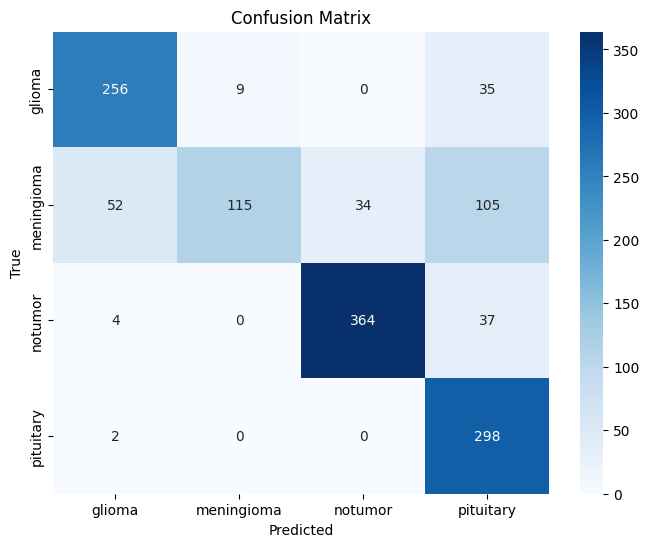

In [16]:
# Predict the classes for the test data
predictions = cnn_model1.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
print(conf_matrix)

# Define dictionary for mapping classes to labels
dict_mapping = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dict_mapping.values(), yticklabels=dict_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [17]:
# classification report
class_report = classification_report(y_test, predicted_classes, target_names=dict_mapping.values())
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

      glioma       0.82      0.85      0.83       300
  meningioma       0.93      0.38      0.53       306
     notumor       0.91      0.90      0.91       405
   pituitary       0.63      0.99      0.77       300

    accuracy                           0.79      1311
   macro avg       0.82      0.78      0.76      1311
weighted avg       0.83      0.79      0.77      1311



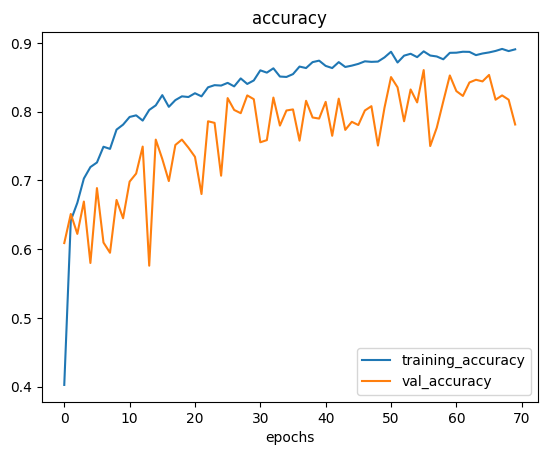

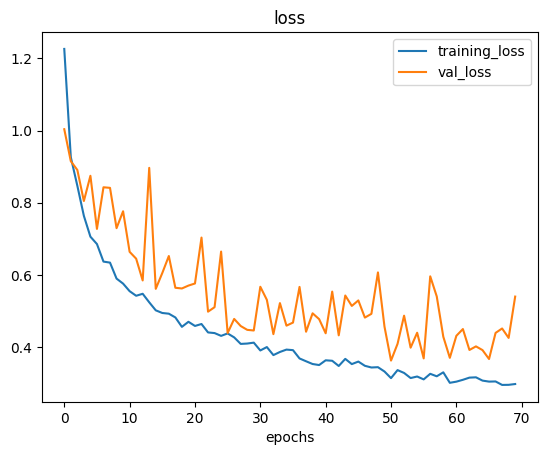

In [18]:
plot_loss_curves(cnn_history1)

### Evaluation of CNN Model Version 2

In [17]:
cnn_model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 10)   │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 220, 220, 10)   │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 110, 110, 128)  │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 10)   │        11,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 108, 108, 10)   │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 106, 106, 10)   │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 53, 53, 128)    │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 10)     │        11,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 51, 51, 10)     │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 49, 49, 10)     │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24, 24, 128)    │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     9,437,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,404,848 (108.36 MB)

 Trainable params: 9,468,242 (36.12 MB)

 Non-trainable params: 120 (480.00 B)

 Optimizer params: 18,936,486 (72.24 MB)

In [18]:
# Evaluate on the test data
cnn_model2.evaluate(x_test, y_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 650ms/step - accuracy: 0.9369 - loss: 0.1732


[0.15629036724567413, 0.9443173408508301]

41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 668ms/step
[[273  21   0   6]
 [  8 280  11   7]
 [  0  10 395   0]
 [  7   3   0 290]]


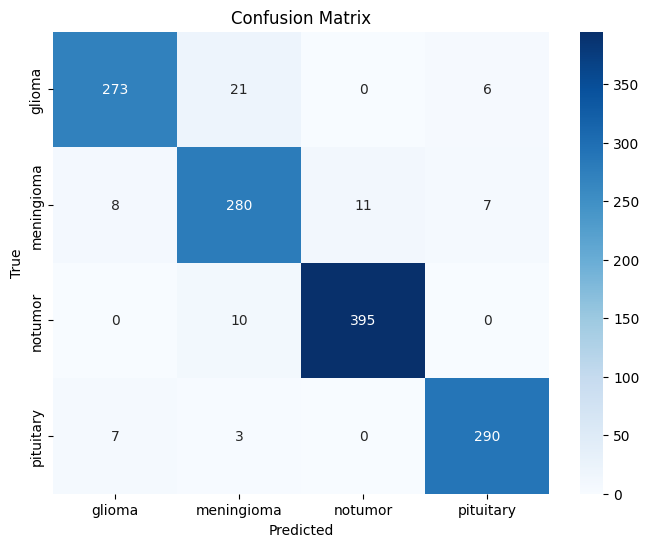

In [19]:
# Predict the classes for the test data
predictions = cnn_model2.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
print(conf_matrix)

# Define dictionary for mapping classes to labels
dict_mapping = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dict_mapping.values(), yticklabels=dict_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [20]:
# classification report
class_report = classification_report(y_test, predicted_classes, target_names=dict_mapping.values())
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

      glioma       0.95      0.91      0.93       300
  meningioma       0.89      0.92      0.90       306
     notumor       0.97      0.98      0.97       405
   pituitary       0.96      0.97      0.96       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



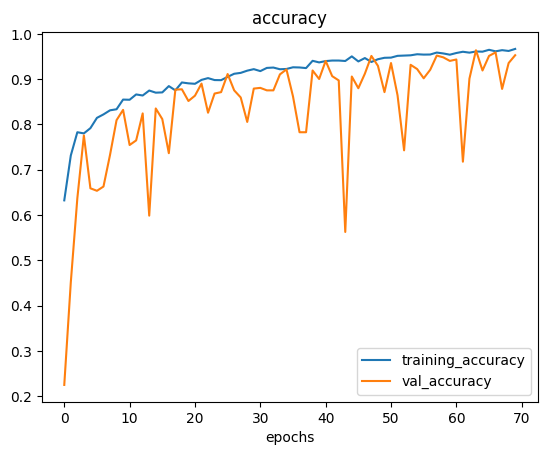

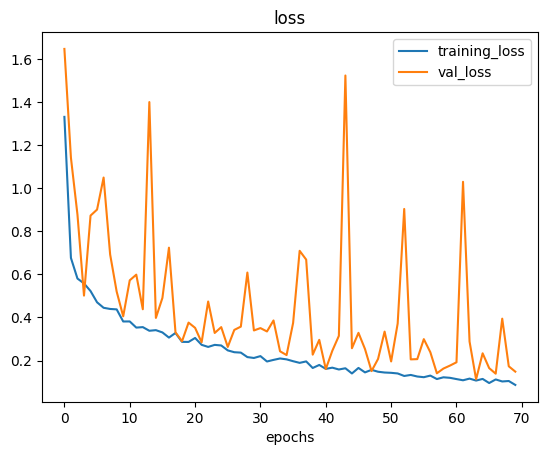

In [21]:
plot_loss_curves(cnn_history2)

### Evaluation of CNN Model Version 3

In [13]:
cnn_model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    22,151,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,532,846 (253.80 MB)

 Trainable params: 22,177,540 (84.60 MB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 44,355,082 (169.20 MB)

In [14]:
# Evaluate on the test data
cnn_model3.evaluate(x_test, y_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 312ms/step - accuracy: 0.8940 - loss: 0.3183


[0.31144288182258606, 0.9031273722648621]

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 313ms/step
[[251  31   1  17]
 [  8 235  28  35]
 [  0   1 400   4]
 [  0   1   1 298]]


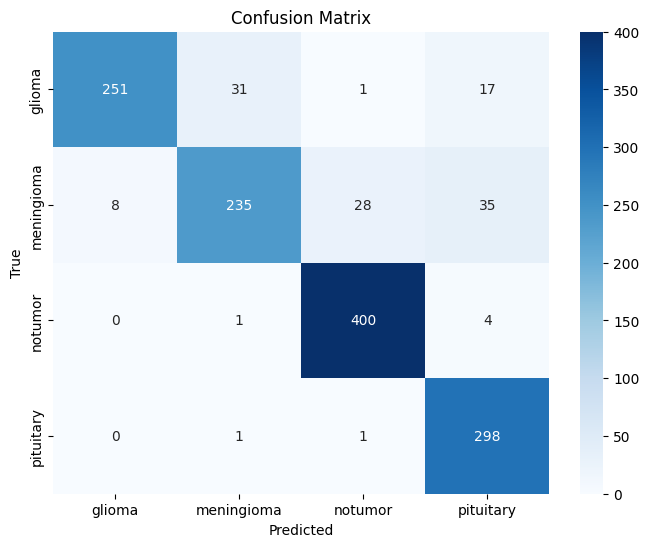

In [15]:
# Predict the classes for the test data
predictions = cnn_model3.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
print(conf_matrix)

# Define dictionary for mapping classes to labels
dict_mapping = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dict_mapping.values(), yticklabels=dict_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# classification report
class_report = classification_report(y_test, predicted_classes, target_names=dict_mapping.values())
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.84      0.90       300
  meningioma       0.88      0.77      0.82       306
     notumor       0.93      0.99      0.96       405
   pituitary       0.84      0.99      0.91       300

    accuracy                           0.90      1311
   macro avg       0.90      0.90      0.90      1311
weighted avg       0.91      0.90      0.90      1311



### Evaluation of CNN Model Version 4

In [16]:
cnn_model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,796,046 (220.47 MB)

 Trainable params: 19,265,348 (73.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,530,698 (146.98 MB)

In [17]:
# Evaluate on the test data
cnn_model4.evaluate(x_test, y_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 628ms/step - accuracy: 0.9838 - loss: 0.0760


[0.08800714462995529, 0.9816933870315552]

41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 627ms/step
[[294   6   0   0]
 [  1 291  12   2]
 [  0   0 405   0]
 [  0   3   0 297]]


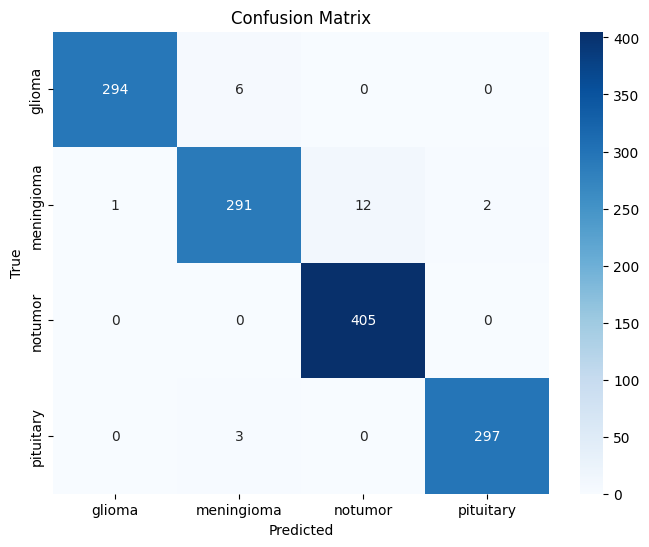

In [18]:
# Predict the classes for the test data
predictions = cnn_model4.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
print(conf_matrix)

# Define dictionary for mapping classes to labels
dict_mapping = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dict_mapping.values(), yticklabels=dict_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# classification report
class_report = classification_report(y_test, predicted_classes, target_names=dict_mapping.values())
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       300
  meningioma       0.97      0.95      0.96       306
     notumor       0.97      1.00      0.99       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



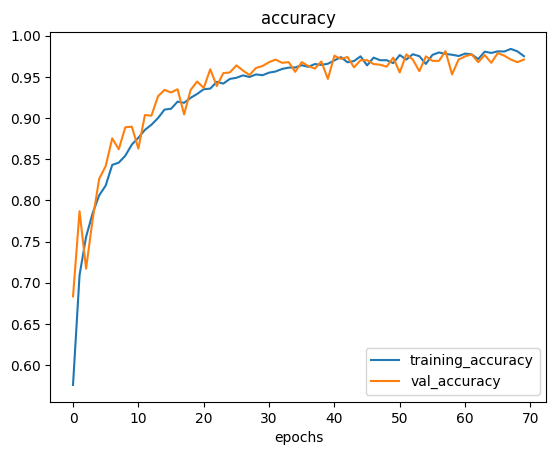

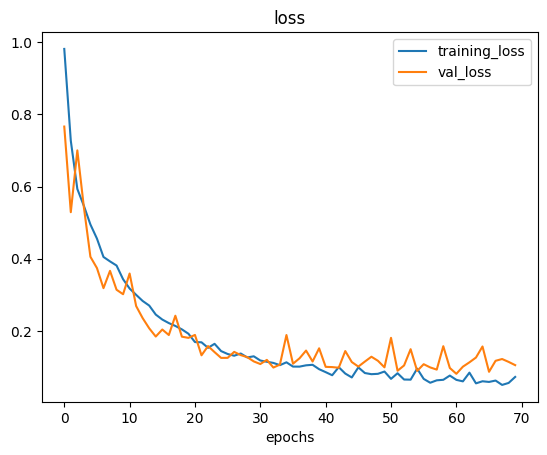

In [20]:
plot_loss_curves(cnn_history4)

### Evaluation of CNN Model Version 5

In [16]:
cnn_model5.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,162,186 (198.98 MB)

 Trainable params: 26,081,092 (99.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,081,094 (99.49 MB)

In [17]:
# Evaluate on the test data
cnn_model5.evaluate(x_test, y_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 29s 718ms/step - accuracy: 0.9641 - loss: 0.1123


[0.15101759135723114, 0.9542334079742432]

41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 749ms/step
[[267  27   0   6]
 [  4 282  15   5]
 [  0   1 404   0]
 [  1   0   1 298]]


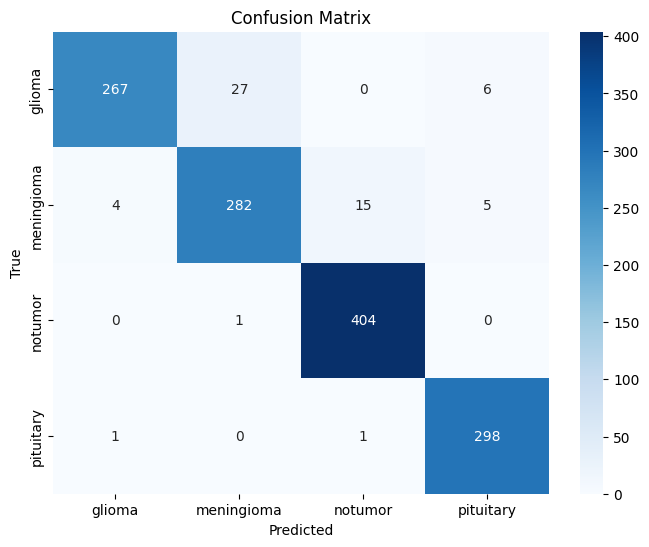

In [18]:
# Predict the classes for the test data
predictions = cnn_model5.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
print(conf_matrix)

# Define dictionary for mapping classes to labels
dict_mapping = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dict_mapping.values(), yticklabels=dict_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# classification report
class_report = classification_report(y_test, predicted_classes, target_names=dict_mapping.values())
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.89      0.93       300
  meningioma       0.91      0.92      0.92       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.96      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



In [ ]:
plot_loss_curves(cnn_history5)

### Evaluation of CNN Model Version 6

In [2]:
cnn_model6.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,081,092 (99.49 MB)

 Trainable params: 26,081,092 (99.49 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Evaluate on the test data
cnn_model6.evaluate(x_test, y_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 29s 692ms/step - accuracy: 0.9775 - loss: 0.0792


[0.08932767063379288, 0.9740656018257141]

41/41 ━━━━━━━━━━━━━━━━━━━━ 29s 699ms/step
[[282  17   0   1]
 [  1 294   7   4]
 [  0   1 404   0]
 [  2   1   0 297]]


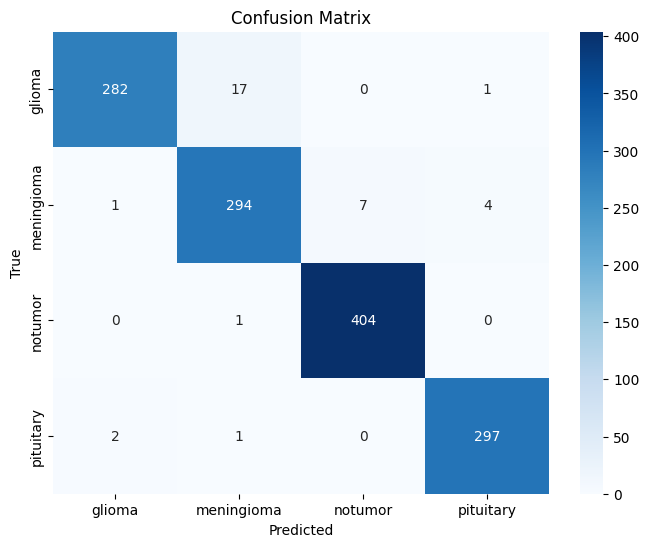

In [19]:
# Predict the classes for the test data
predictions = cnn_model6.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
print(conf_matrix)

# Define dictionary for mapping classes to labels
dict_mapping = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dict_mapping.values(), yticklabels=dict_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [20]:
# classification report
class_report = classification_report(y_test, predicted_classes, target_names=dict_mapping.values())
print("Classification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.94      0.96       300
  meningioma       0.94      0.96      0.95       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



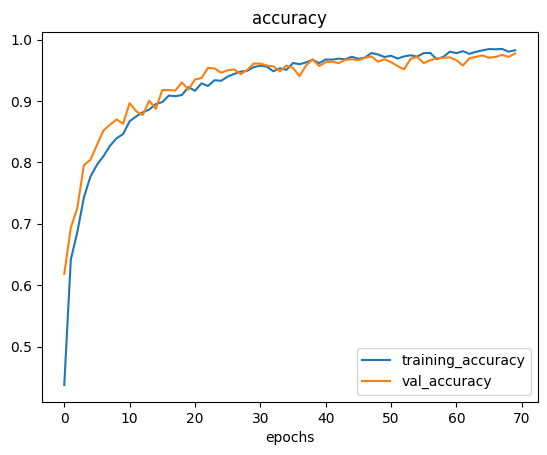

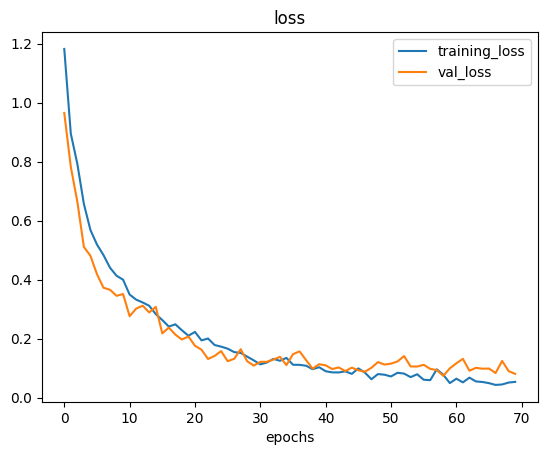

In [23]:
plot_loss_curves(cnn_history6)

### Evaluation of CNN Model Version 7

In [18]:
model_inception_v3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    26,214,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,453,678 (383.20 MB)

 Trainable params: 26,216,964 (100.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 52,433,930 (200.02 MB)

In [19]:
# Evaluate on the test data
model_inception_v3.evaluate(x_test, y_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9374 - loss: 0.1962


[0.19621732831001282, 0.9405034184455872]

41/41 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step
[[278  17   0   5]
 [ 16 254   6  30]
 [  1   2 402   0]
 [  0   1   0 299]]


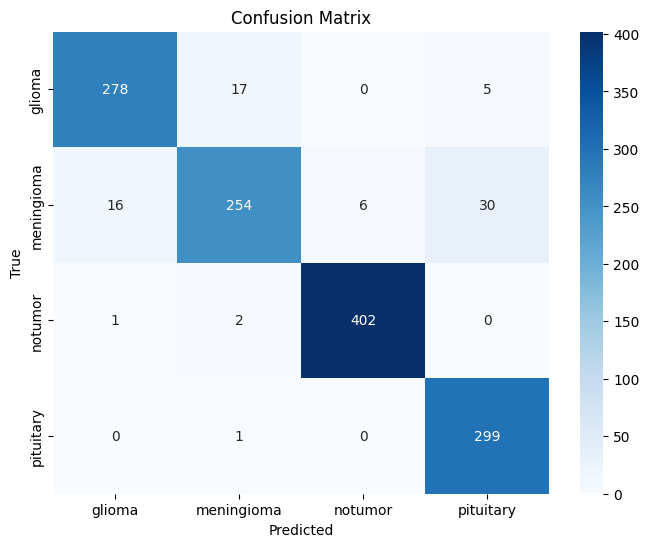

In [20]:
# Predict the classes for the test data
predictions = model_inception_v3.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
print(conf_matrix)

# Define dictionary for mapping classes to labels
dict_mapping = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dict_mapping.values(), yticklabels=dict_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [21]:
# classification report
class_report = classification_report(y_test, predicted_classes, target_names=dict_mapping.values())
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.93      0.93       300
  meningioma       0.93      0.83      0.88       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.90      1.00      0.94       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



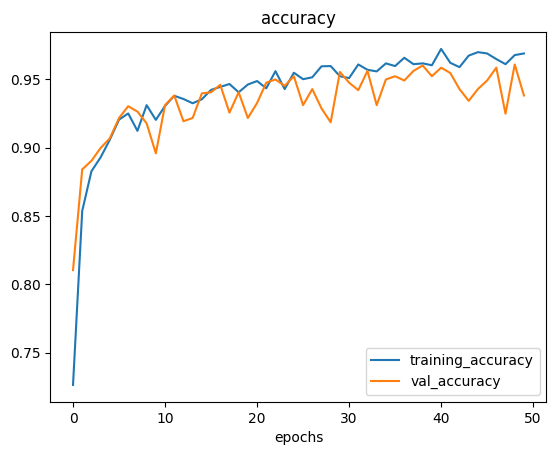

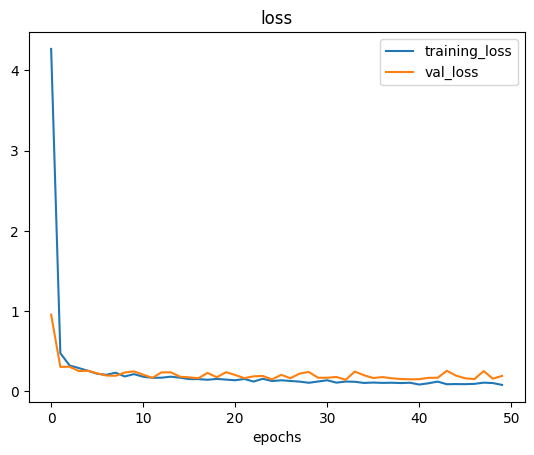

In [22]:
plot_loss_curves(cnn_history7)

### Evaluation of CNN Model Version 8

In [23]:
model_densenet121.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,115,534 (320.88 MB)

 Trainable params: 25,692,676 (98.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 51,385,354 (196.02 MB)

In [24]:
# Evaluate on the test data
model_densenet121.evaluate(x_test, y_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9442 - loss: 0.2149


[0.24001829326152802, 0.9382150769233704]

41/41 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step
[[242  49   0   9]
 [  1 286   2  17]
 [  0   1 404   0]
 [  1   1   0 298]]


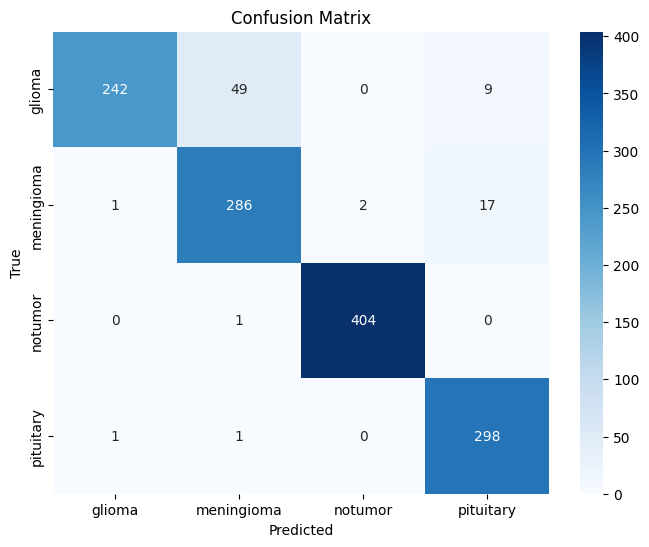

In [25]:
# Predict the classes for the test data
predictions = model_densenet121.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
print(conf_matrix)

# Define dictionary for mapping classes to labels
dict_mapping = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dict_mapping.values(), yticklabels=dict_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# classification report
class_report = classification_report(y_test, predicted_classes, target_names=dict_mapping.values())
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.81      0.89       300
  meningioma       0.85      0.93      0.89       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.92      0.99      0.96       300

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311



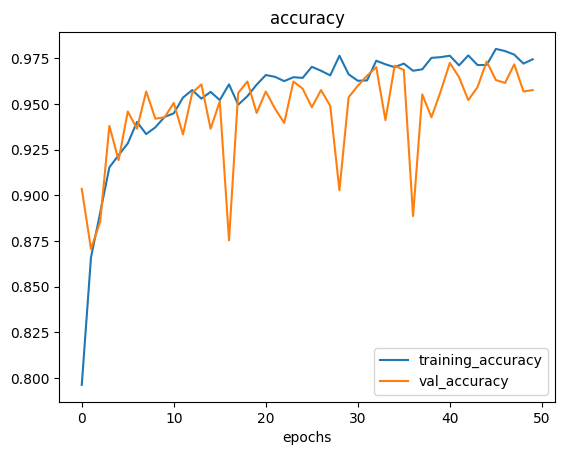

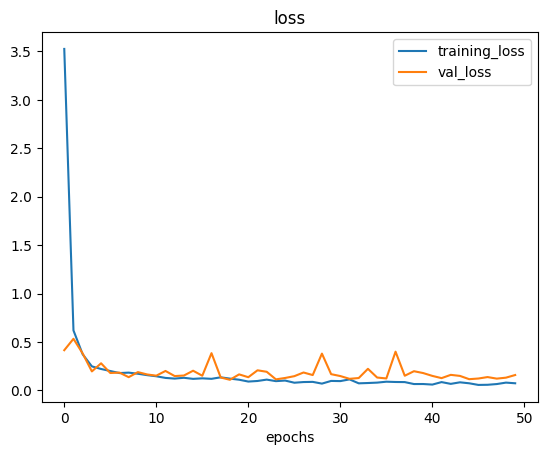

In [27]:
plot_loss_curves(cnn_history8)

### Evaluation of CNN Model Version 9

In [16]:
model_efficientnet_b0.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    32,113,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,395,185 (382.98 MB)

 Trainable params: 32,115,204 (122.51 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 64,230,410 (245.02 MB)

In [17]:
# Evaluate on the test data
model_efficientnet_b0.evaluate(x_test, y_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.2287 - loss: 1.3872


[1.3870505094528198, 0.22883294522762299]

41/41 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step
[[300   0   0   0]
 [306   0   0   0]
 [405   0   0   0]
 [300   0   0   0]]


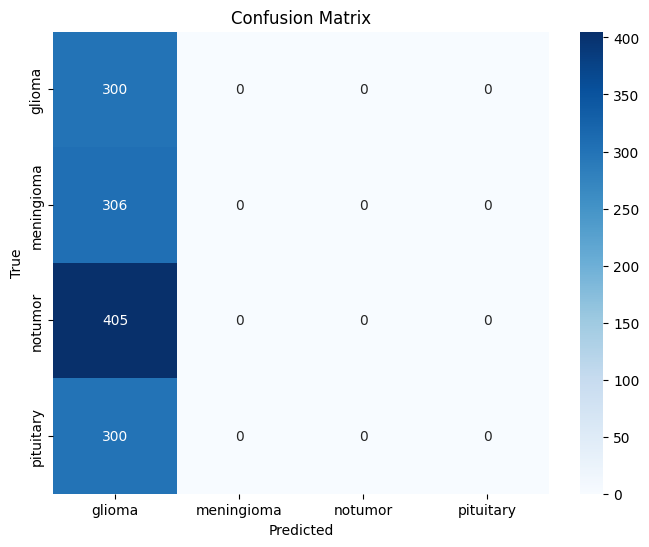

In [18]:
# Predict the classes for the test data
predictions = model_efficientnet_b0.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
print(conf_matrix)

# Define dictionary for mapping classes to labels
dict_mapping = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dict_mapping.values(), yticklabels=dict_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# classification report
class_report = classification_report(y_test, predicted_classes, target_names=dict_mapping.values())
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

      glioma       0.23      1.00      0.37       300
  meningioma       0.00      0.00      0.00       306
     notumor       0.00      0.00      0.00       405
   pituitary       0.00      0.00      0.00       300

    accuracy                           0.23      1311
   macro avg       0.06      0.25      0.09      1311
weighted avg       0.05      0.23      0.09      1311



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


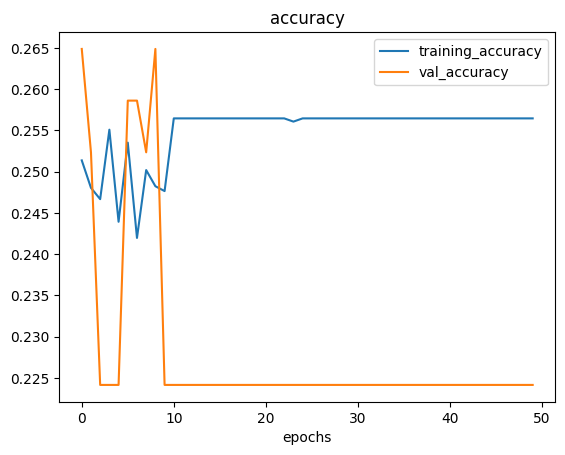

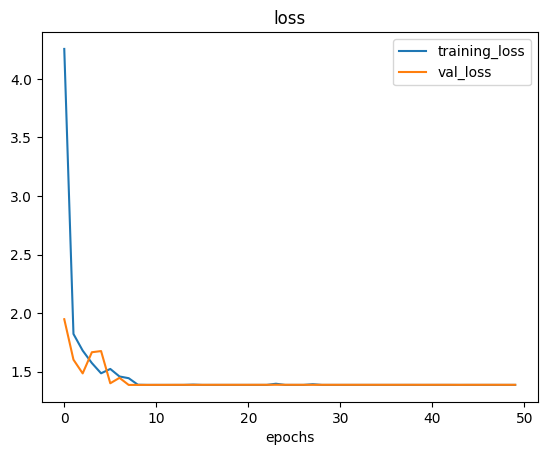

In [20]:
plot_loss_curves(cnn_history9)

# Save the best performing model

In [14]:
# Save a model
cnn_model4.save('final_cnn_model.h5')